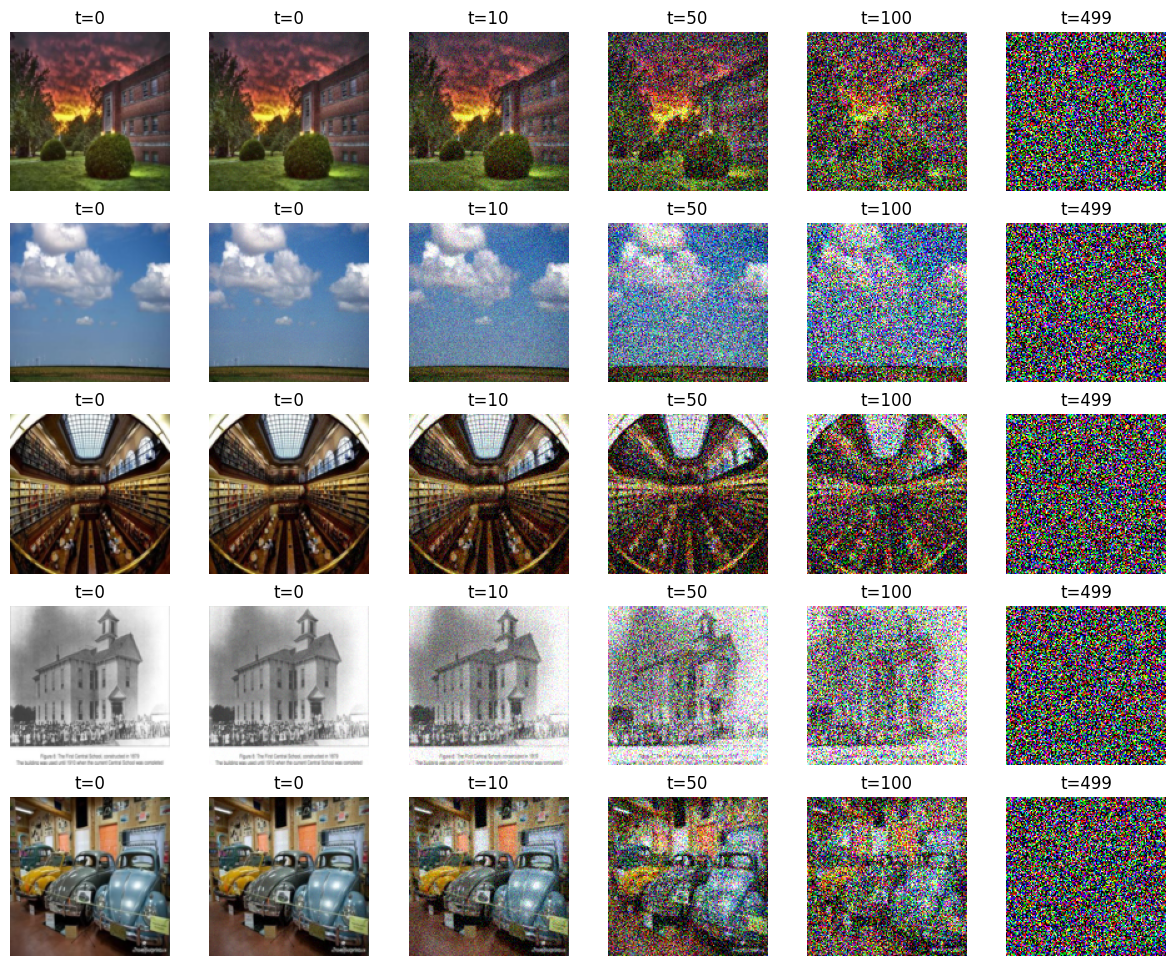

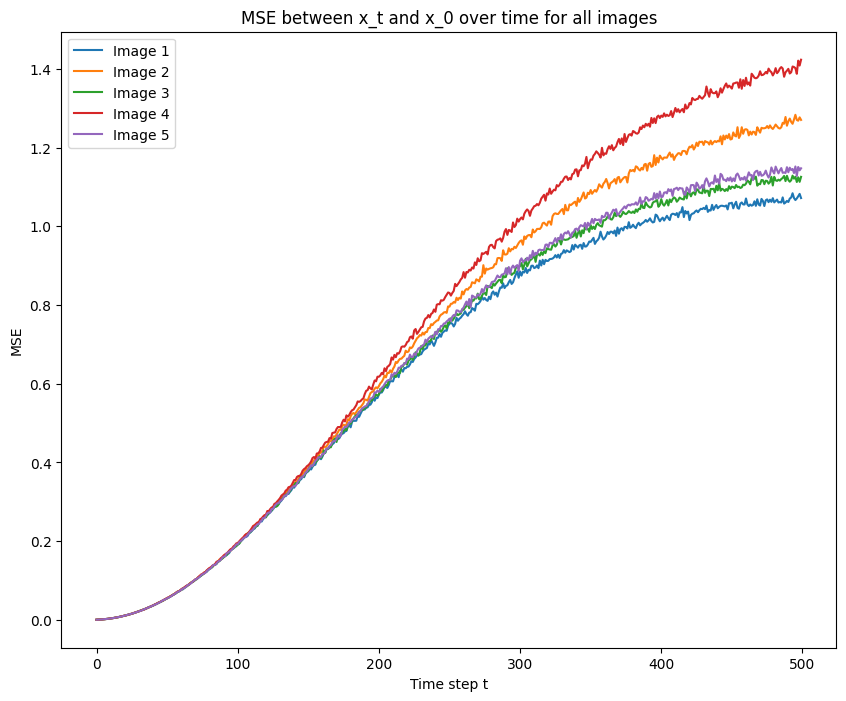

<Figure size 640x480 with 0 Axes>

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import glob

# Ensure reproducibility
torch.manual_seed(0)

transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor()
])


image_dir = './sample_images/' 
image_paths = glob.glob(image_dir + '*.jpg')[:5]

images = []
for image_path in image_paths:
    img = Image.open(image_path).convert('RGB') 
    img_tensor = transform(img)
    images.append(img_tensor)

images = torch.stack(images)

T = 500  
betas = torch.linspace(1e-4, 0.02, T) 

alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def forward_diffusion_sample(x0, t):
    """
    Adds Gaussian noise to the original image x0 at time step t.

    Args:
        x0: Original image tensor of shape (batch_size, channels, height, width)
        t: Time step (int)

    Returns:
        x_t: Noisy image at time step t
    """
    sqrt_alpha_bar_t = torch.sqrt(alpha_bars[t]).reshape(1, 1, 1, 1).to(x0.device)
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bars[t]).reshape(1, 1, 1, 1).to(x0.device)
    epsilon = torch.randn_like(x0)
    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t

time_steps_to_plot = [0, 10, 50, 100, 499] 
mse_all_images = [] 


fig, axs = plt.subplots(len(images), len(time_steps_to_plot) + 1, figsize=(15, 12))

for idx, img in enumerate(images):
    x0 = img.unsqueeze(0)  

    axs[idx, 0].imshow(np.transpose(x0[0].numpy(), (1, 2, 0)))
    axs[idx, 0].set_title('t=0')
    axs[idx, 0].axis('off')

    mse_list = []

    for t in range(T):
        x_t = forward_diffusion_sample(x0, t)
        mse = nn.MSELoss()(x_t, x0).item()
        mse_list.append(mse)

        if t in time_steps_to_plot:
            col = time_steps_to_plot.index(t) + 1
            axs[idx, col].imshow(np.clip(np.transpose(x_t[0].numpy(), (1, 2, 0)), 0, 1))
            axs[idx, col].set_title(f't={t}')
            axs[idx, col].axis('off')
    
    mse_all_images.append(mse_list)

plt.figure(figsize=(10, 8))
for idx, mse_list in enumerate(mse_all_images):
    plt.plot(range(T), mse_list, label=f'Image {idx + 1}')
plt.xlabel('Time step t')
plt.ylabel('MSE')
plt.title('MSE between x_t and x_0 over time for all images')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()
